# Transfer learning в решении задачи классификации цветов
Датасет классификации цветов (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) состоит из 102 видов цветов встречаемых в Великобритании. Для каждого класса есть от 40 до 258 примеров, чего мало для обучения с нуля:

<img src="http://bennycheung.github.io/images/deep-transfer-learning-on-small-dataset/flower_train_samples_700.jpg" style="width:50%">

In [2]:
!pip install -q efficientnet

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import tarfile
import sys
import os

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import tensorflow.keras.callbacks as C
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras import optimizers
import efficientnet.tfkeras as efn

from sklearn.model_selection import train_test_split

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', keras.__version__)

['flower-dataset-102']
Python       : 3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
Numpy        : 1.18.2
Tensorflow   : 2.1.0
Keras        : 2.2.4-tf


In [4]:
# Проверяем что у нас работает GPU
tf.test.gpu_device_name()

'/device:GPU:0'

# Setup

In [5]:
EPOCHS               = 5
BATCH_SIZE           = 8
LR                   = 1e-3
VAL_SPLIT            = 0.2

CLASS_NUM            = 102
IMG_SIZE             = 250
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/flower-dataset-102/'
PATH = "../working/flower/"

In [6]:
# Setting seed for reproducibility
os.makedirs(PATH, exist_ok=False)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)  
PYTHONHASHSEED = 0

# Data

In [8]:
# прочитаем все названия файлов прям из архива и таргеты к ним
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH+"102flowers.tgz"))
df['Category'] = scipy.io.loadmat(DATA_PATH+'imagelabels.mat')['labels'][0] - 1  # классы (0, 1, 2, ...)
df['Category'] = df['Category'].astype(str)

df.head(5)

,Id,Category
0,jpg/image_00001.jpg,76
1,jpg/image_00002.jpg,76
2,jpg/image_00003.jpg,76
3,jpg/image_00004.jpg,76
4,jpg/image_00005.jpg,76


Число категорий: 102


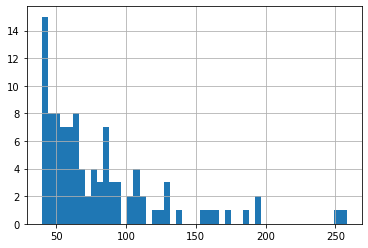

In [22]:
print('Число категорий:', df['Category'].nunique())
df['Category'].value_counts().hist(bins=50);

In [23]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
opened_tar = tarfile.open(DATA_PATH+"102flowers.tgz")
opened_tar.extractall(PATH)

print(os.listdir(PATH+'jpg')[:5])

Распаковываем картинки
['image_00383.jpg', 'image_03623.jpg', 'image_01770.jpg', 'image_00274.jpg', 'image_04838.jpg']


Пример картинок (random sample)


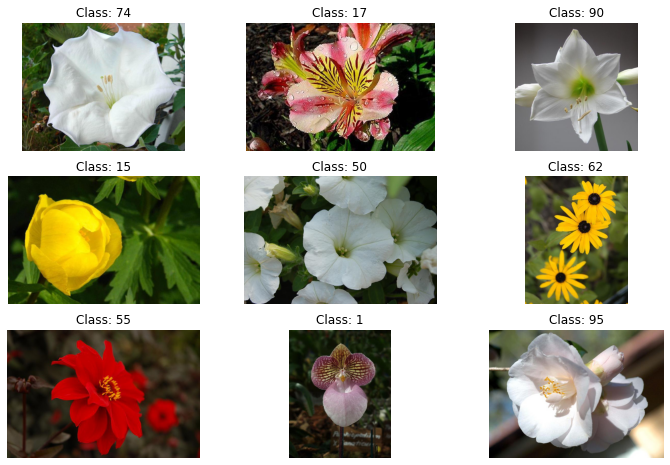

In [24]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

Пример картинок (random sample)


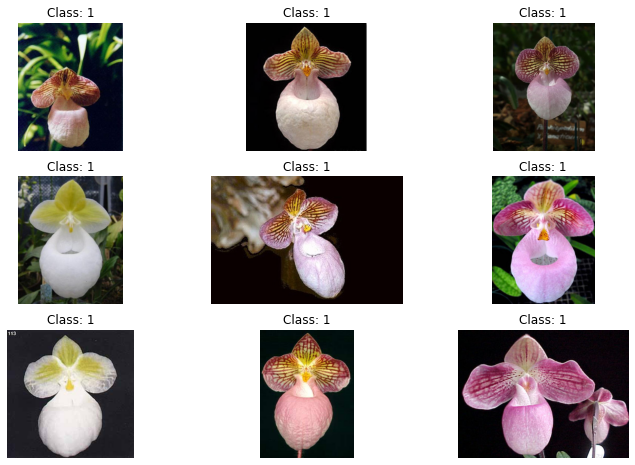

In [25]:
# убедимся что метки классов подгрузились верно
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = df[df['Category']=='1'].sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+path)
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

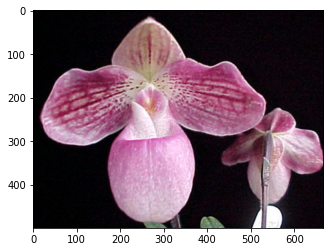

(667, 500)

In [26]:
# как видим изображения имеют разный размер
image = PIL.Image.open(PATH+path)
imgplot = plt.imshow(image)
plt.show()
image.size

 ## Stratify Split

In [27]:
# трейн / тест
train_files, test_files, train_labels, test_labels = \
    train_test_split(
    df['Id'], df['Category'], test_size=0.2,
    random_state=42, stratify=df['Category']
)

train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels

train_files.shape, test_files.shape

((6551, 2), (1638, 2))

In [28]:
train_files.head(5)

,Id,Category
2361,jpg/image_02362.jpg,42
512,jpg/image_00513.jpg,87
5969,jpg/image_05970.jpg,68
6251,jpg/image_06252.jpg,60
516,jpg/image_00517.jpg,87


In [40]:
train_files['Category'].value_counts()

50    206
76    201
45    157
72    155
88    147
     ... 
2      32
26     32
33     32
44     32
0      32
Name: Category, Length: 102, dtype: int64

In [30]:
test_files['Category'].value_counts()

50    52
76    50
72    39
45    39
88    37
      ..
2      8
38     8
44     8
15     8
0      8
Name: Category, Length: 102, dtype: int64

### Data augmentation

In [41]:
# Аугментация данных очень важна когда у нас не большой датасет (как в нашем случае)

train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    rotation_range = 50,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

### datagen

In [42]:
# "Заворачиваем" наши данные в generator

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED
)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


Пример картинок из train_generator


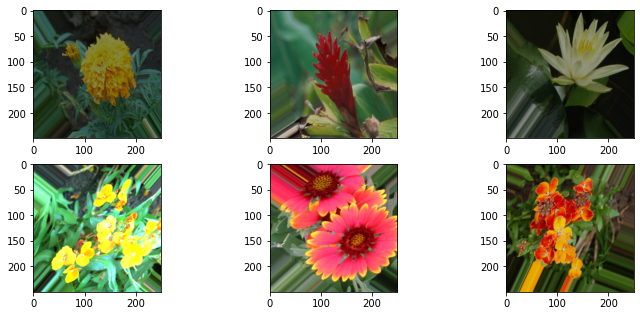

In [46]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x,y = train_generator.next()
print('Пример картинок из train_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

Пример картинок из test_generator


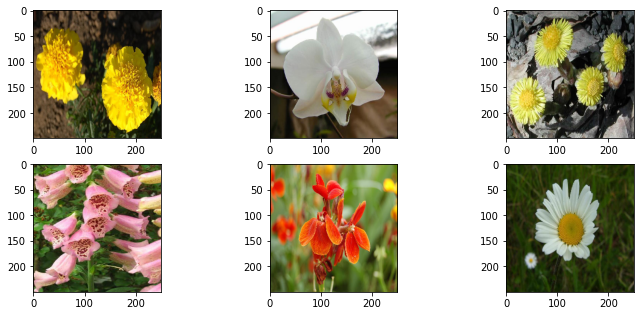

In [47]:
x,y = test_generator.next()
print('Пример картинок из test_generator')
plt.figure(figsize=(12,8))

for i in range(0,6):
    image = x[i]
    plt.subplot(3,3, i+1)
    plt.imshow(image)
    #plt.title('Class: '+str(y[i]))
    #plt.axis('off')
plt.show()

# Model

In [51]:
base_model = efn.EfficientNetB6(weights='imagenet', include_top=False, input_shape=input_shape)

# base_model.summary()

In [52]:
# first: train only the top layers (which were randomly initialized)
base_model.trainable = False

In [53]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               235110    
Total params: 41,195,246
Trainable params: 235,110
Non-trainable params: 40,960,136
_________________________________________________________________


In [55]:
# сколько слоев
print(len(model.layers))

len(model.trainable_variables)

3


2

In [56]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7afcd6f28320> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7afcd6e90240> True
<tensorflow.python.keras.layers.core.Dense object at 0x7afcd6e90358> True


## Fit

In [57]:
LR=0.001
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [58]:
checkpoint = ModelCheckpoint(
    'best_model.hdf5', monitor=['val_accuracy'],
    verbose=1, mode='max'
)

earlystop = EarlyStopping(
    monitor='val_accuracy', patience=5,
    restore_best_weights=True
)

callbacks_list = [checkpoint, earlystop]

In [59]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 23s 110ms/step - loss: 4.6604 - accuracy: 0.0031
Accuracy: 0.31%


In [60]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator, 
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=5, callbacks=callbacks_list
)

Train for 818 steps, validate for 204 steps
Epoch 1/5
817/818 [============================>.] - ETA: 0s - loss: 2.7079 - accuracy: 0.3923
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 169s 207ms/step - loss: 2.7064 - accuracy: 0.3925 - val_loss: 1.3624 - val_accuracy: 0.6979
Epoch 2/5
817/818 [============================>.] - ETA: 0s - loss: 1.5544 - accuracy: 0.6167
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 154s 188ms/step - loss: 1.5537 - accuracy: 0.6170 - val_loss: 0.9769 - val_accuracy: 0.7647
Epoch 3/5
817/818 [============================>.] - ETA: 0s - loss: 1.2318 - accuracy: 0.6946
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 154s 188ms/step - loss: 1.2321 - accuracy: 0.6945 - val_loss: 0.7335 - val_accuracy: 0.8150
Epoch 4/5
817/818 [============================>.] - ETA: 0s - loss: 1.0619 - accuracy: 0.7347
Epoch 00004: saving model to best_mo

Удивительно на сколько эта модель хорошо умеет извлекать признаки!
Даже без дообучения получаем столь высокий Accuracy.

In [61]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [62]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 16s 76ms/step - loss: 0.5909 - accuracy: 0.8504
Accuracy: 85.04%


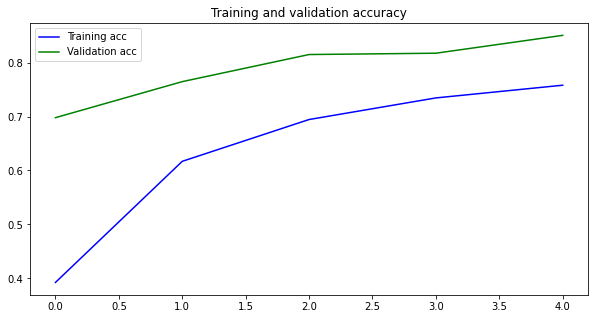

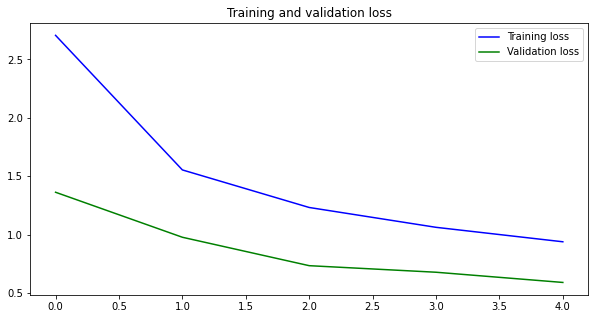

In [63]:
def plot_history(history):
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'g', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    #plt.figure()
    plt.figure(figsize=(10,5))
    #plt.style.use('dark_background')
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'g', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

plot_history(history)

## Step 2

In [64]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  659


In [66]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [67]:
len(base_model.trainable_variables)

291

In [68]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.training.Model object at 0x7afcd6f28320> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7afcd6e90240> True
<tensorflow.python.keras.layers.core.Dense object at 0x7afcd6e90358> True


In [69]:
LR=0.0001
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [70]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 8, 8, 2304)        40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 102)               235110    
Total params: 41,195,246
Trainable params: 37,931,580
Non-trainable params: 3,263,666
_________________________________________________________________


In [71]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 20s 97ms/step - loss: 0.5909 - accuracy: 0.8504
Accuracy: 85.04%


In [72]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator, 
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs = 10, callbacks = callbacks_list
)

Train for 818 steps, validate for 204 steps
Epoch 1/10
817/818 [============================>.] - ETA: 0s - loss: 0.9295 - accuracy: 0.7578
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 184s 225ms/step - loss: 0.9294 - accuracy: 0.7578 - val_loss: 0.2943 - val_accuracy: 0.9234
Epoch 2/10
817/818 [============================>.] - ETA: 0s - loss: 0.3524 - accuracy: 0.9018
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 162s 198ms/step - loss: 0.3523 - accuracy: 0.9017 - val_loss: 0.1936 - val_accuracy: 0.9498
Epoch 3/10
817/818 [============================>.] - ETA: 0s - loss: 0.1867 - accuracy: 0.9466
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 164s 200ms/step - loss: 0.1865 - accuracy: 0.9467 - val_loss: 0.1290 - val_accuracy: 0.9688
Epoch 4/10
817/818 [============================>.] - ETA: 0s - loss: 0.1242 - accuracy: 0.9648
Epoch 00004: saving model to bes

In [73]:
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [74]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 16s 77ms/step - loss: 0.1115 - accuracy: 0.9737
Accuracy: 97.37%


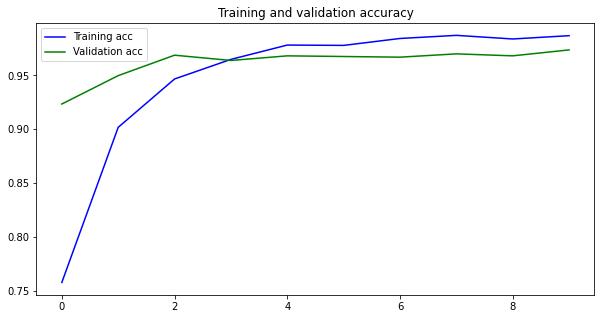

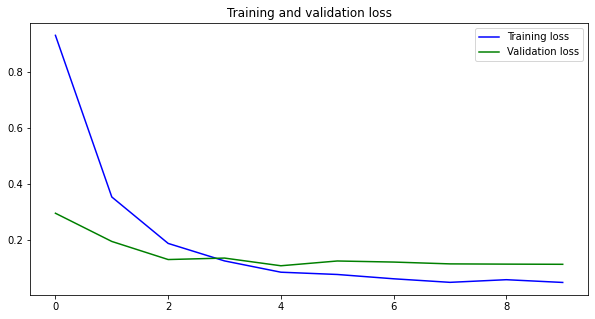

In [75]:
plot_history(history)

## Step 3

In [76]:
base_model.trainable = True

In [77]:
LR=0.00001
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [78]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator, 
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=10,
    callbacks=callbacks_list
)

Train for 818 steps, validate for 204 steps
Epoch 1/10
817/818 [============================>.] - ETA: 0s - loss: 0.0513 - accuracy: 0.9849
Epoch 00001: saving model to best_model.hdf5
818/818 [==============================] - 308s 377ms/step - loss: 0.0513 - accuracy: 0.9849 - val_loss: 0.1114 - val_accuracy: 0.9737
Epoch 2/10
817/818 [============================>.] - ETA: 0s - loss: 0.0327 - accuracy: 0.9914
Epoch 00002: saving model to best_model.hdf5
818/818 [==============================] - 276s 337ms/step - loss: 0.0327 - accuracy: 0.9914 - val_loss: 0.1002 - val_accuracy: 0.9767
Epoch 3/10
817/818 [============================>.] - ETA: 0s - loss: 0.0251 - accuracy: 0.9940
Epoch 00003: saving model to best_model.hdf5
818/818 [==============================] - 276s 337ms/step - loss: 0.0250 - accuracy: 0.9940 - val_loss: 0.0956 - val_accuracy: 0.9761
Epoch 4/10
817/818 [============================>.] - ETA: 0s - loss: 0.0204 - accuracy: 0.9950
Epoch 00004: saving model to bes

In [79]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [80]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

205/205 [==============================] - 16s 76ms/step - loss: 0.0784 - accuracy: 0.9829
Accuracy: 98.29%


# Step 4

In [81]:
EPOCHS               = 10
BATCH_SIZE           = 4 # уменьшаем batch если сеть большая, иначе не влезет в память на GPU
LR                   = 1e-4

IMG_SIZE             = 512
IMG_CHANNELS         = 3
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

In [82]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255, 
    #rotation_range = 90,
    #shear_range=0.2,
    zoom_range=[0.75,1.25],
    #brightness_range=[0.5, 1.5],
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1. / 255)

In [83]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED,)

Found 6551 validated image filenames belonging to 102 classes.
Found 1638 validated image filenames belonging to 102 classes.


In [84]:
base_model = efn.EfficientNetB6(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

In [85]:
model=M.Sequential()
model.add(base_model)
model.add(L.GlobalAveragePooling2D(),)
model.add(L.Dense(CLASS_NUM, activation='softmax'))

In [86]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Model)      (None, 16, 16, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 102)               235110    
Total params: 41,195,246
Trainable params: 40,970,814
Non-trainable params: 224,432
_________________________________________________________________


In [87]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [88]:
model.load_weights('best_model.hdf5')

In [89]:
# Обучаем
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=test_generator, 
    validation_steps=test_generator.samples // test_generator.batch_size,
    epochs=EPOCHS,
    callbacks=callbacks_list
)

Train for 1637 steps, validate for 409 steps
Epoch 1/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.1837 - accuracy: 0.9528
Epoch 00001: saving model to best_model.hdf5
1637/1637 [==============================] - 1122s 685ms/step - loss: 0.1841 - accuracy: 0.9527 - val_loss: 0.0576 - val_accuracy: 0.9902
Epoch 2/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.0597 - accuracy: 0.9872
Epoch 00002: saving model to best_model.hdf5
1637/1637 [==============================] - 1088s 664ms/step - loss: 0.0597 - accuracy: 0.9872 - val_loss: 0.0643 - val_accuracy: 0.9872
Epoch 3/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.0399 - accuracy: 0.9913
Epoch 00003: saving model to best_model.hdf5
1637/1637 [==============================] - 1088s 664ms/step - loss: 0.0399 - accuracy: 0.9913 - val_loss: 0.0852 - val_accuracy: 0.9829
Epoch 4/10
1636/1637 [============================>.] - ETA: 0s - loss: 0.0351 - accuracy: 0.9922
Epoch 00004: s

In [90]:
model.save('../working/model_step4.hdf5')
model.load_weights('best_model.hdf5')

In [91]:
scores = model.evaluate_generator(test_generator, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

410/410 [==============================] - 52s 126ms/step - loss: 0.0719 - accuracy: 0.9902
Accuracy: 99.02%


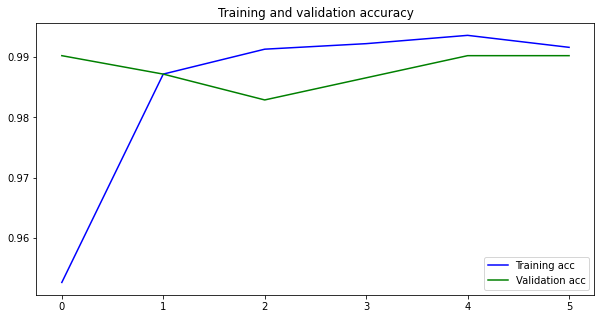

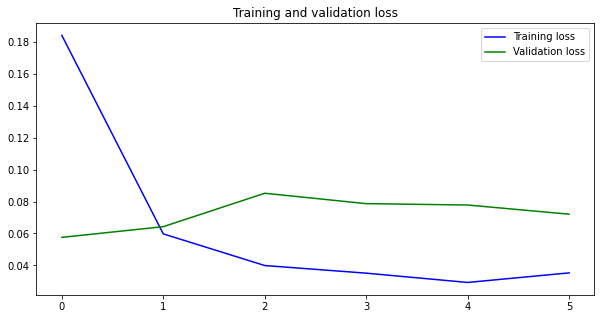

In [92]:
plot_history(history)

# Final Score

In [93]:
from sklearn.metrics import accuracy_score

In [94]:
predictions = model.predict_generator(test_generator, verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

410/410 [==============================] - 54s 131ms/step


In [95]:
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
test_files.index = test_files['Id']
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)
tmp_y.head(5)

,Predict,Category
Id,,
jpg/image_05001.jpg,46,46
jpg/image_07204.jpg,6,6
jpg/image_04014.jpg,11,11
jpg/image_07420.jpg,93,93
jpg/image_01122.jpg,45,45


In [96]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 99.02%


# TTA

In [97]:
model.load_weights('best_model.hdf5')

In [99]:
test_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 90,
    shear_range=0.2,
    zoom_range=[0.75,1.25],
    brightness_range=[0.5, 1.5],
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [100]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_files,
    directory=PATH,
    x_col="Id",
    y_col="Category",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False, 
    seed=RANDOM_SEED
)

Found 1638 validated image filenames belonging to 102 classes.


In [104]:
tta_steps = 10
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

410/410 [==============================] - 106s 257ms/step


In [105]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]
filenames_with_dir=test_generator.filenames
submission = pd.DataFrame({'Predict':predictions}, columns=['Predict'], index=filenames_with_dir)
tmp_y = pd.concat([submission['Predict'], test_files['Category']], axis=1, sort=False)

In [106]:
print('Accuracy: %.2f%%' % (accuracy_score(tmp_y['Category'], tmp_y['Predict'],)*100))

Accuracy: 98.72%


## clean

In [107]:
# Clean PATH
import shutil
shutil.rmtree(PATH)